In [90]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

print(torch.__version__)
print(np.__version__)

%load_ext nb_black

1.9.0
1.19.3
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [145]:
parent_path = os.path.join(os.getcwd())

train_df = pd.read_csv(f"{parent_path}/temperature/training.csv")
test_df = pd.read_csv(f"{parent_path}/temperature/testing.csv")

<IPython.core.display.Javascript object>

In [132]:
test_df

,Celsius,Fahrenheit
0,259,NaN
1,2351,NaN
2,2112,NaN
3,2239,NaN
4,1016,NaN
...,...,...
7995,1147,NaN
7996,567,NaN
7997,2367,NaN
7998,685,NaN


<IPython.core.display.Javascript object>

In [111]:
def print_model_summary(linear_model):
    print(f"Weight: {linear_model.weight.item()}")
    print(f"Bias: {linear_model.bias.item()}")
    return round(linear_model.weight.item()), round(linear_model.bias.item())

<IPython.core.display.Javascript object>

In [93]:
# Convert 1-D tensors' t_c and t_u into a matrix of size samples * features. (Samples = 11 and features = 1)

t_c = torch.tensor(
    train_df["Celsius"],
    requires_grad=True,
    dtype=torch.float32,
).unsqueeze(1)
t_f = torch.tensor(
    train_df["Fahrenheit"],
    requires_grad=True,
    dtype=torch.float32,
).unsqueeze(1)

t_c.shape, t_f.shape

(torch.Size([16000, 1]), torch.Size([16000, 1]))

<IPython.core.display.Javascript object>

In [94]:
# Create a optimizer for linear model to learn the differences in temperature
linear_model = nn.Linear(1, 1)

optimizer = optim.SGD(linear_model.parameters(), lr=0.01)
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[0.8624]], requires_grad=True),
   Parameter containing:
   tensor([0.4895], requires_grad=True)],
  'lr': 0.01,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False}]

<IPython.core.display.Javascript object>

In [96]:
# Create a training loop for training linear_model
def training_loop(
    n_epochs, optimizer, model, loss_fn, t_c_train, t_f_train, t_c_val, t_f_val
):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_c_train)
        loss_train = loss_fn(t_p_train, t_f_train)

        t_p_val = model(t_c_val)
        loss_val = loss_fn(t_p_val, t_f_val)

        optimizer.zero_grad()
        loss_train.backward(retain_graph=True)
        optimizer.step()

        if epoch == 1 or epoch % 100 == 0:
            print(
                "Epoch %d, Training loss %.4f, Validation loss %.4f"
                % (epoch, float(loss_train), float(loss_val))
            )

<IPython.core.display.Javascript object>

In [97]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

<IPython.core.display.Javascript object>

In [98]:
# Train
train_c = t_c[train_indices]
train_f = t_f[train_indices]

# Validation
val_c = t_c[val_indices]
val_f = t_f[val_indices]

<IPython.core.display.Javascript object>

In [108]:
# Normalize training ONLY
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

n_train_c = torch.from_numpy(x_scaler.fit_transform(train_c.detach().numpy()))
n_val_c = torch.from_numpy(y_scaler.fit_transform(val_c.detach().numpy()))

<IPython.core.display.Javascript object>

In [109]:
# X is celcius and Y is farenight
training_loop(
    n_epochs=10000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_c_train=n_train_c,
    t_f_train=train_f,
    t_c_val=n_val_c,
    t_f_val=val_f,
)

Epoch 1, Training loss 6991742.5000, Validation loss 6796294.5000
Epoch 100, Training loss 827341.4375, Validation loss 838368.0000
Epoch 200, Training loss 607422.1875, Validation loss 624376.8125
Epoch 300, Training loss 466081.0312, Validation loss 479645.1250
Epoch 400, Training loss 357749.8750, Validation loss 368197.8438
Epoch 500, Training loss 274598.7500, Validation loss 282620.7812
Epoch 600, Training loss 210774.3594, Validation loss 216931.9844
Epoch 700, Training loss 161784.6094, Validation loss 166511.0469
Epoch 800, Training loss 124181.3594, Validation loss 127809.2500
Epoch 900, Training loss 95318.2266, Validation loss 98102.8672
Epoch 1000, Training loss 73163.7031, Validation loss 75301.1094
Epoch 1100, Training loss 56158.5039, Validation loss 57799.1406
Epoch 1200, Training loss 43105.6953, Validation loss 44364.9961
Epoch 1300, Training loss 33086.8555, Validation loss 34053.4609
Epoch 1400, Training loss 25396.5273, Validation loss 26138.4727
Epoch 1500, Train

<IPython.core.display.Javascript object>

In [112]:
w, b = print_model_summary(linear_model)
w, b

Weight: 4499.8544921875
Bias: 32.073486328125


(4500, 32)

<IPython.core.display.Javascript object>

In [147]:
test_scale = MinMaxScaler()
test_df["scaled_celsius"] = test_scale.fit_transform(
    np.array(test_df["Celsius"]).reshape(-1, 1)
)

<IPython.core.display.Javascript object>

In [149]:
test_df["Fahrenheit"] = w * test_cel + b

<IPython.core.display.Javascript object>

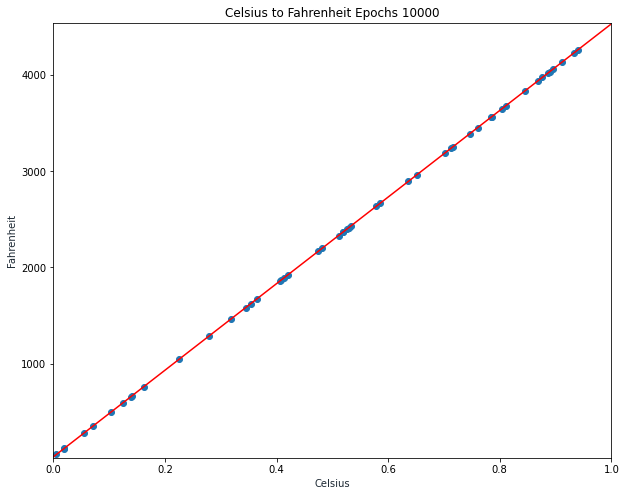

<IPython.core.display.Javascript object>

In [167]:
points_to_display = 50

plt.figure(figsize=((10, 8)))
plt.xlim([0, 1])
plt.ylim([test_df["Fahrenheit"].min() - 10, test_df["Fahrenheit"].max() + 10])

plt.scatter(
    test_df["scaled_celsius"][:points_to_display],
    test_df["Fahrenheit"][:points_to_display],
)
y = w * x + b
plt.plot(x, y, "-r")

plt.title("Celsius to Fahrenheit Epochs 10000")
plt.xlabel("Celsius", color="#1C2833")
plt.ylabel("Fahrenheit", color="#1C2833")

plt.show()